#### **Context**

The <a href="https://www.kaggle.com/datasets/jillanisofttech/market-segmentation-in-insurance-unsupervised">sample Dataset</a> summarizes the usage behavior of about 9000 active credit cardholders during the last 6 months. The file is at a customer level with 18 behavioral variables.

##### **Credit Card Dataset Column Meanings**

| Column Name | Meaning in Credit Card Context |
|-------------|-------------------------------|
| CUST_ID | Unique identifier for each customer |
| BALANCE | Average balance amount maintained on the credit card |
| BALANCE_FREQUENCY | How frequently the customer maintains a balance (0-1 scale) |
| PURCHASES | Total amount of purchases made using the credit card |
| ONEOFF_PURCHASES | Total amount spent on one-time/single purchases |
| INSTALLMENTS_PURCHASES | Total amount spent on installment purchases |
| CASH_ADVANCE | Total amount taken as cash advances from the credit card |
| PURCHASES_FREQUENCY | How frequently the customer makes purchases (0-1 scale) |
| ONEOFF_PURCHASES_FREQUENCY | How frequently the customer makes one-time purchases (0-1 scale) |
| PURCHASES_INSTALLMENTS_FREQUENCY | How frequently the customer makes installment purchases (0-1 scale) |
| CASH_ADVANCE_FREQUENCY | How frequently the customer takes cash advances (0-1 scale) |
| CASH_ADVANCE_TRX | Number of cash advance transactions made |
| PURCHASES_TRX | Number of purchase transactions made |
| CREDIT_LIMIT | Maximum credit limit available on the card |
| PAYMENTS | Total amount of payments made to the credit card |
| MINIMUM_PAYMENTS | Total amount of minimum payments made |
| PRC_FULL_PAYMENT | Percentage of full payments made (vs. partial payments) |
| TENURE | Number of months the customer has held the credit card |

### Importing necessary packages

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest, RandomForestRegressor, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
import shap
from kneed import KneeLocator
from scipy.spatial.distance import cdist
from scipy.stats.mstats import winsorize

from cluster_visualizer import ClusterVisualizer


import warnings
warnings.filterwarnings('ignore')

### Importing Data and Exploring it

In [165]:
df = pd.read_csv('Customer Data.csv')

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [167]:
null_counts = df.isna().sum()
null_counts[null_counts > 0]

CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64

In [168]:
df.describe(include='all')

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
unique,8950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,C19190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,NaN,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,NaN,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,NaN,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,NaN,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000


### Preprocessing

In [169]:
# Drop CUST_ID column before processing
cust_id_df = df['CUST_ID']
df = df.drop('CUST_ID', axis=1)
# Handle missing values by applying IterativeImputer with RandomForestRegressor
df_numeric = df.copy()
imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, random_state=42), max_iter= 20)
df = pd.DataFrame(
    imputer.fit_transform(df_numeric), 
    columns=df_numeric.columns,
    index=df_numeric.index
)

df.insert(loc=0, column='CUST_ID', value=cust_id_df)

### Feature Engineering

In [170]:
df_risk = df.copy()

# High-risk indicators
df_risk['DEBT_TO_LIMIT_RATIO'] = df_risk['BALANCE'] / (df_risk['CREDIT_LIMIT'] + 1e-6)
df_risk['CASH_ADVANCE_DEPENDENCY'] = df_risk['CASH_ADVANCE'] / (df_risk['PURCHASES'] + df_risk['CASH_ADVANCE'] + 1)
# Payment stability indicators
df_risk['PAYMENT_TO_BALANCE_RATIO'] = df_risk['PAYMENTS'] / (df_risk['BALANCE'] + 1)
df_risk['MINIMUM_PAYMENT_DEPENDENCY'] = df_risk['MINIMUM_PAYMENTS'] / (df_risk['PAYMENTS'] + 1)
# 1. Activity and engagement patterns
df_risk['TOTAL_ACTIVITY'] = (df_risk['PURCHASES_FREQUENCY'] + 
                            df_risk['CASH_ADVANCE_FREQUENCY'] + 
                            df_risk['BALANCE_FREQUENCY']) / 3
df_risk['TRANSACTION_FREQUENCY'] = df_risk['PURCHASES_TRX'] + df_risk['CASH_ADVANCE_TRX']
# Credit utilization patterns
df_risk['CASH_ADVANCE_INTENSITY'] = df_risk['CASH_ADVANCE'] / df_risk['TENURE']

# 1. PAYMENT BEHAVIOR RISK (Most important in credit risk)
df_risk['PAYMENT_STRESS_RATIO'] = df_risk['MINIMUM_PAYMENTS'] / (df_risk['BALANCE'] + 1)
df_risk['PAYMENT_COVERAGE'] = df_risk['PAYMENTS'] / (df_risk['MINIMUM_PAYMENTS'] + 1)
df_risk['REVOLVING_BALANCE_RATIO'] = (df_risk['BALANCE'] - df_risk['PAYMENTS']) / (df_risk['BALANCE'] + 1)
df_risk['RISK_PROXY'] = np.where(
    df_risk['PAYMENT_STRESS_RATIO'] > df_risk['PAYMENT_STRESS_RATIO'].quantile(0.75),
    1,  # High risk
    0   # Low risk
)

# 2. CASH ADVANCE PATTERNS (High-risk behavior)
df_risk['CASH_ADVANCE_VELOCITY'] = df_risk['CASH_ADVANCE_TRX'] / (df_risk['TENURE'] + 1)
df_risk['CASH_VS_PURCHASE_RATIO'] = df_risk['CASH_ADVANCE'] / (df_risk['PURCHASES'] + 1)
df_risk['CASH_ADVANCE_SIZE'] = np.where(  
    df_risk['CASH_ADVANCE_TRX'] > 0,  
    df_risk['CASH_ADVANCE'] / df_risk['CASH_ADVANCE_TRX'],  
    0  # Handle zero transactions  
)  

# 3. CREDIT UTILIZATION SOPHISTICATION
df_risk['CREDIT_UTILIZATION_TREND'] = df_risk['BALANCE'] / (df_risk['CREDIT_LIMIT'] + 1)
df_risk['AVAILABLE_CREDIT_USAGE'] = (df_risk['CREDIT_LIMIT'] - df_risk['BALANCE']) / (df_risk['CREDIT_LIMIT'] + 1)

# 4. PURCHASE BEHAVIOR PATTERNS
df_risk['PURCHASE_STABILITY'] = df_risk['PURCHASES'] / (df_risk['PURCHASES_TRX'] + 1)  # Avg purchase size
df_risk['INSTALLMENT_PREFERENCE'] = df_risk['INSTALLMENTS_PURCHASES'] / (df_risk['PURCHASES'] + 1)
df_risk['ONEOFF_PREFERENCE'] = df_risk['ONEOFF_PURCHASES'] / (df_risk['PURCHASES'] + 1)

# 5. ACTIVITY CONSISTENCY
df_risk['USAGE_CONSISTENCY'] = (df_risk['PURCHASES_FREQUENCY'] + 
                                df_risk['BALANCE_FREQUENCY']) / 2
df_risk['DORMANCY_RISK'] = 1 - df_risk['USAGE_CONSISTENCY']

# 6. TENURE-BASED RISK
df_risk['BALANCE_PER_MONTH'] = df_risk['BALANCE'] / (df_risk['TENURE'] + 1)
df_risk['PAYMENT_VELOCITY'] = df_risk['PAYMENTS'] / (df_risk['TENURE'] + 1)

In [171]:
# Select core risk features for clustering
risk_features = [
    # Original high-value columns
    'BALANCE', 'CASH_ADVANCE', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE', 'CASH_ADVANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'BALANCE_FREQUENCY',
    
    # Key engineered features (existing)
    'DEBT_TO_LIMIT_RATIO',           # Utilization risk
    'CASH_ADVANCE_DEPENDENCY',       # Behavioral risk
    'PAYMENT_TO_BALANCE_RATIO',      # Payment capacity
    'MINIMUM_PAYMENT_DEPENDENCY',    # Payment stress
    'TOTAL_ACTIVITY',                # Account engagement
    'CASH_ADVANCE_INTENSITY',        # Monthly cash advance risk
    'TRANSACTION_FREQUENCY',         # Account inactivity
    
    # New enhanced risk features
    'PAYMENT_STRESS_RATIO',          # Minimum payment burden
    # 'RISK_PROXY',
    'PAYMENT_COVERAGE',              # Payment adequacy
    'REVOLVING_BALANCE_RATIO',       # Balance revolving pattern
    'CASH_ADVANCE_VELOCITY',         # Cash advance frequency per month
    'CASH_VS_PURCHASE_RATIO',        # Cash vs purchase behavior
    'CASH_ADVANCE_SIZE',             # Average cash advance amount
    'CREDIT_UTILIZATION_TREND',      # Alternative utilization measure
    'AVAILABLE_CREDIT_USAGE',        # Credit headroom usage
    'PURCHASE_STABILITY',            # Average purchase size
    'INSTALLMENT_PREFERENCE',        # Installment usage pattern
    'ONEOFF_PREFERENCE',             # One-off purchase pattern
    'USAGE_CONSISTENCY',             # Account usage consistency
    'DORMANCY_RISK',                 # Account inactivity risk
    'BALANCE_PER_MONTH',             # Monthly balance growth
    'PAYMENT_VELOCITY'               # Monthly payment rate
]
X = df_risk[risk_features]


### Feature Selection

In [82]:
df_risk['RISK_PROXY'] = np.where(
    df_risk['PAYMENT_STRESS_RATIO'] > df_risk['PAYMENT_STRESS_RATIO'].quantile(0.75),
    1,  # High risk
    0   # Low risk
)

In [83]:
# Feature importance using SHAP values
X_train, X_val, y_train, y_val = train_test_split(
    df_risk[risk_features], 
    df_risk['RISK_PROXY'],
    test_size=0.2,
    random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [84]:
# Explain model predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

from sklearn.pipeline import Pipeline

# For pipelines
if isinstance(model, Pipeline):
    print("Pipeline steps:", model.named_steps.keys())
    try:
        print("Transformed features:", model[:-1].get_feature_names_out())
    except AttributeError:
        print("Transformer doesn't support feature names")

# Create SHAP summary
mean_abs_shap = np.abs(shap_values[1].T).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': risk_features,
    'importance': mean_abs_shap
}).sort_values('importance', ascending=False)


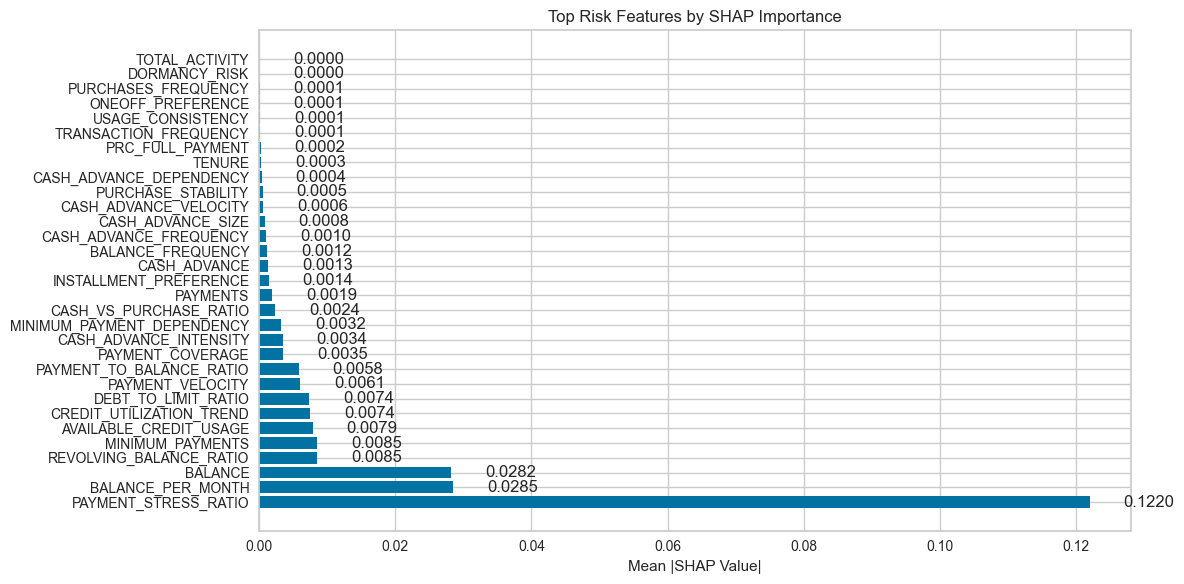

In [85]:
# Select top features (adjust based on elbow in importance plot)
plt.figure(figsize=(12, 6))
bars = plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Top Risk Features by SHAP Importance')
plt.xlabel('Mean |SHAP Value|')
# Add value labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005,  # x-position (slightly right of bar)
            bar.get_y() + bar.get_height()/2,  # y-position (middle of bar)
            f'{width:.4f}',  # formatted value
            va='center', ha='left')  # vertical and horizontal alignment
plt.tight_layout()
plt.show()

In [137]:
# Select top N features (N where cumulative importance > 95%)
cumulative_importance = feature_importance['importance'].cumsum() / feature_importance['importance'].sum()
n_features = np.argmax(cumulative_importance > 0.95) + 1
selected_features = feature_importance['feature'].iloc[:n_features].tolist()

print(f"Selected {n_features} features: {selected_features}")

Selected 13 features: ['PAYMENT_STRESS_RATIO', 'BALANCE_PER_MONTH', 'BALANCE', 'REVOLVING_BALANCE_RATIO', 'MINIMUM_PAYMENTS', 'AVAILABLE_CREDIT_USAGE', 'CREDIT_UTILIZATION_TREND', 'DEBT_TO_LIMIT_RATIO', 'PAYMENT_VELOCITY', 'PAYMENT_TO_BALANCE_RATIO', 'PAYMENT_COVERAGE', 'CASH_ADVANCE_INTENSITY', 'MINIMUM_PAYMENT_DEPENDENCY']


### Data Preprocessing

In [138]:
right_skewed_features = ['BALANCE', 'PAYMENTS', 'MINIMUM_PAYMENTS',
                                    'TRANSACTION_FREQUENCY']

heavy_tailed_features = ['CASH_ADVANCE', 'PRC_FULL_PAYMENT', 'CASH_ADVANCE_FREQUENCY', 'DEBT_TO_LIMIT_RATIO', 'CASH_ADVANCE_DEPENDENCY'
                        , 'PAYMENT_TO_BALANCE_RATIO', 'MINIMUM_PAYMENT_DEPENDENCY', 'CASH_ADVANCE_INTENSITY', 'BALANCE_FREQUENCY',
                        'PAYMENT_STRESS_RATIO', 'PAYMENT_COVERAGE', 'REVOLVING_BALANCE_RATIO','CASH_ADVANCE_VELOCITY','CASH_VS_PURCHASE_RATIO',  
                        'CASH_ADVANCE_SIZE', 'CREDIT_UTILIZATION_TREND', 'AVAILABLE_CREDIT_USAGE', 'PURCHASE_STABILITY', 'INSTALLMENT_PREFERENCE',
                        'ONEOFF_PREFERENCE', 'BALANCE_PER_MONTH', 'PAYMENT_VELOCITY', 'RISK_PROXY']

# ===== ROBUST CLUSTERING WITH SELECTED FEATURES =====
X_selected = df_risk[selected_features]

# Apply transformations only to selected features
for feature in selected_features:
    if feature in right_skewed_features:
        X_selected[feature] = np.log1p(X_selected[feature])
    if feature in heavy_tailed_features:
        X_selected[feature] = winsorize(X_selected[feature], limits=[0.05, 0.05])

# Final scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_selected)

### Clustering Analysis

To determine the optimal number of clusters, I check if the difference is big (<= 1) then I choose silhouette score because it's more objective than KMeans and handles well the imblances in clusters.

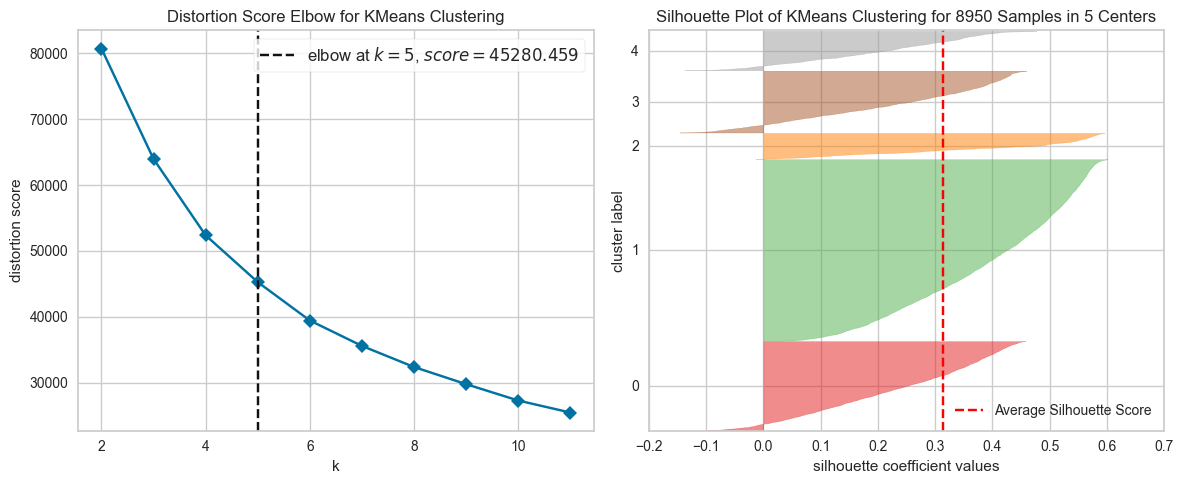

In [139]:
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

# 1. Determine optimal K
plt.figure(figsize=(12, 5))

# Elbow method
ax1 = plt.subplot(121)
visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=20), k=(2,12), timings=False, ax=ax1)
visualizer.fit(X_scaled)
visualizer.finalize()

# Silhouette analysis
ax2 = plt.subplot(122)
sil_visualizer = SilhouetteVisualizer(KMeans(visualizer.elbow_value_, random_state=42, n_init=20), ax=ax2)
sil_visualizer.fit(X_scaled)
sil_visualizer.finalize()

plt.tight_layout()
plt.show()

Hierarchical clustering with k=6 is clearly optimal:
- Elbow method: After 6, the line starts to flatten
- Silhouette: Hierarchical peaks at k=6 (0.325) vs K-means at k=10 (0.297)
- Davies-Bouldin: Both methods minimize around k=6-7, with hierarchical slightly better
- Calinski-Harabasz: Less decisive but shows hierarchical performing well at k=6

In [140]:
# 2. Final clustering with interpretable algorithm
optimal_k = visualizer.elbow_value_
print(f"Optimal number of clusters is: {optimal_k}")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(X_scaled)

Optimal number of clusters is: 5


### Risk Segment Profiling

In [141]:
# 3. Add clusters to dataframe
df_risk['RISK_CLUSTER'] = cluster_labels

# ===== CLUSTER PROFILING =====
def profile_clusters(df, cluster_col='RISK_CLUSTER', risk_features=None):
    """Robust cluster profiling with error handling"""
    if risk_features is None:
        risk_features = [col for col in df.columns if col != cluster_col]
    
    profiles = []
    
    # Calculate population statistics first
    pop_stats = {col: df[col].mean() for col in risk_features}
    
    for cluster in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col] == cluster]
        profile = {
            'Cluster': cluster,
            'Size': len(cluster_data)
        }
        
        # Add all risk features with comparison to population
        for col in risk_features:
            profile[col] = cluster_data[col].mean()
            profile[f'{col}_vs_pop'] = (profile[col] - pop_stats[col]) / pop_stats[col]
        
        profiles.append(profile)
    
    profile_df = pd.DataFrame(profiles).set_index('Cluster')
    
    # Add dominance flags
    for col in risk_features:
        profile_df[f'{col}_dominance'] = profile_df[col].apply(
            lambda x: '↑↑' if x > pop_stats[col]*1.5 
                    else '↑' if x > pop_stats[col]*1.2
                    else '≈' if x >= pop_stats[col]*0.8 
                    else '↓' if x >= pop_stats[col]*0.5 
                    else '↓↓'
        )
    
    return profile_df

# Generate profiles
cluster_profile = profile_clusters(
    df_risk, 
    'RISK_CLUSTER', 
    selected_features
)

In [155]:
# Define CORE risk dimensions (grouped by risk type)
risk_dimensions = {
    # Payment Behavior
    'PAYMENT_STRESS_RATIO',
    'MINIMUM_PAYMENT_DEPENDENCY', 
    'PAYMENT_COVERAGE',
    
    # Credit Utilization
    'DEBT_TO_LIMIT_RATIO',
    'CREDIT_UTILIZATION_TREND',
    'AVAILABLE_CREDIT_USAGE',
    
    # Cash Advance Behavior
    'CASH_ADVANCE_INTENSITY',
    # 'CASH_VS_PURCHASE_RATIO',
    
    # Balance Patterns
    'REVOLVING_BALANCE_RATIO',
    'BALANCE_PER_MONTH',
    
    # Activity Patterns
    'PAYMENT_VELOCITY'
}

# Display key characteristics with formatting
def display_cluster_characteristics(profile_df, risk_features, n=3):
    """Safe display function with column validation"""
    required_columns = {'Size'}.union(set(risk_features))
    missing_cols = required_columns - set(profile_df.columns)
    
    if missing_cols:
        print(f"Warning: Missing columns {missing_cols} in profile data")
        return
    
    for cluster in profile_df.index:
        print(f"\n=== CLUSTER {cluster} (Size: {profile_df.loc[cluster, 'Size']}) ===")
        
        # Get top elevated risk factors
        elevated_risks = []
        for col in risk_features:
            if col in profile_df.columns:
                dominance = profile_df.loc[cluster, f'{col}_dominance']
                if dominance in ['↑↑', '↑']:
                    elevated_risks.append((
                        col,
                        profile_df.loc[cluster, col],
                        dominance,
                        profile_df.loc[cluster, f'{col}_vs_pop']
                    ))
        
        # Sort by deviation from population
        elevated_risks.sort(key=lambda x: abs(x[3]), reverse=True)
        
        print("Top Risk Factors:")
        for factor in elevated_risks[:n]:
            print(f"  {factor[0]}: {factor[1]:.2f} ({factor[2]}, {factor[3]:+.0%} vs pop)")
        
        # Critical combinations check
        debt_check = 'DEBT_TO_LIMIT_RATIO' in profile_df.columns
        stress_check = 'PAYMENT_STRESS_RATIO' in profile_df.columns
        
        if debt_check and stress_check:
            if (profile_df.loc[cluster, 'DEBT_TO_LIMIT_RATIO'] > 0.8 and 
                profile_df.loc[cluster, 'PAYMENT_STRESS_RATIO'] > 0.7):
                print("⚠️ CRITICAL: High debt + payment stress")


display_cluster_characteristics(cluster_profile, risk_dimensions)


=== CLUSTER 0 (Size: 2006) ===
Top Risk Factors:
  PAYMENT_COVERAGE: 18.84 (↑↑, +188% vs pop)
  PAYMENT_VELOCITY: 210.85 (↑↑, +54% vs pop)
  AVAILABLE_CREDIT_USAGE: 0.91 (↑, +49% vs pop)

=== CLUSTER 1 (Size: 4085) ===
Top Risk Factors:
  REVOLVING_BALANCE_RATIO: 0.13 (↑↑, -101% vs pop)
  DEBT_TO_LIMIT_RATIO: 0.56 (↑, +44% vs pop)
  CREDIT_UTILIZATION_TREND: 0.56 (↑, +44% vs pop)

=== CLUSTER 2 (Size: 582) ===
Top Risk Factors:
  PAYMENT_STRESS_RATIO: 12.55 (↑↑, +521% vs pop)
  PAYMENT_COVERAGE: 11.69 (↑↑, +79% vs pop)
  AVAILABLE_CREDIT_USAGE: 0.99 (↑↑, +63% vs pop)

=== CLUSTER 3 (Size: 1391) ===
Top Risk Factors:
  CASH_ADVANCE_INTENSITY: 403.24 (↑↑, +353% vs pop)
  BALANCE_PER_MONTH: 370.63 (↑↑, +196% vs pop)
  PAYMENT_VELOCITY: 316.01 (↑↑, +131% vs pop)

=== CLUSTER 4 (Size: 886) ===
Top Risk Factors:
  MINIMUM_PAYMENT_DEPENDENCY: 947.05 (↑↑, +753% vs pop)
  PAYMENT_STRESS_RATIO: 6.46 (↑↑, +220% vs pop)
  REVOLVING_BALANCE_RATIO: -5.20 (↑↑, -66% vs pop)


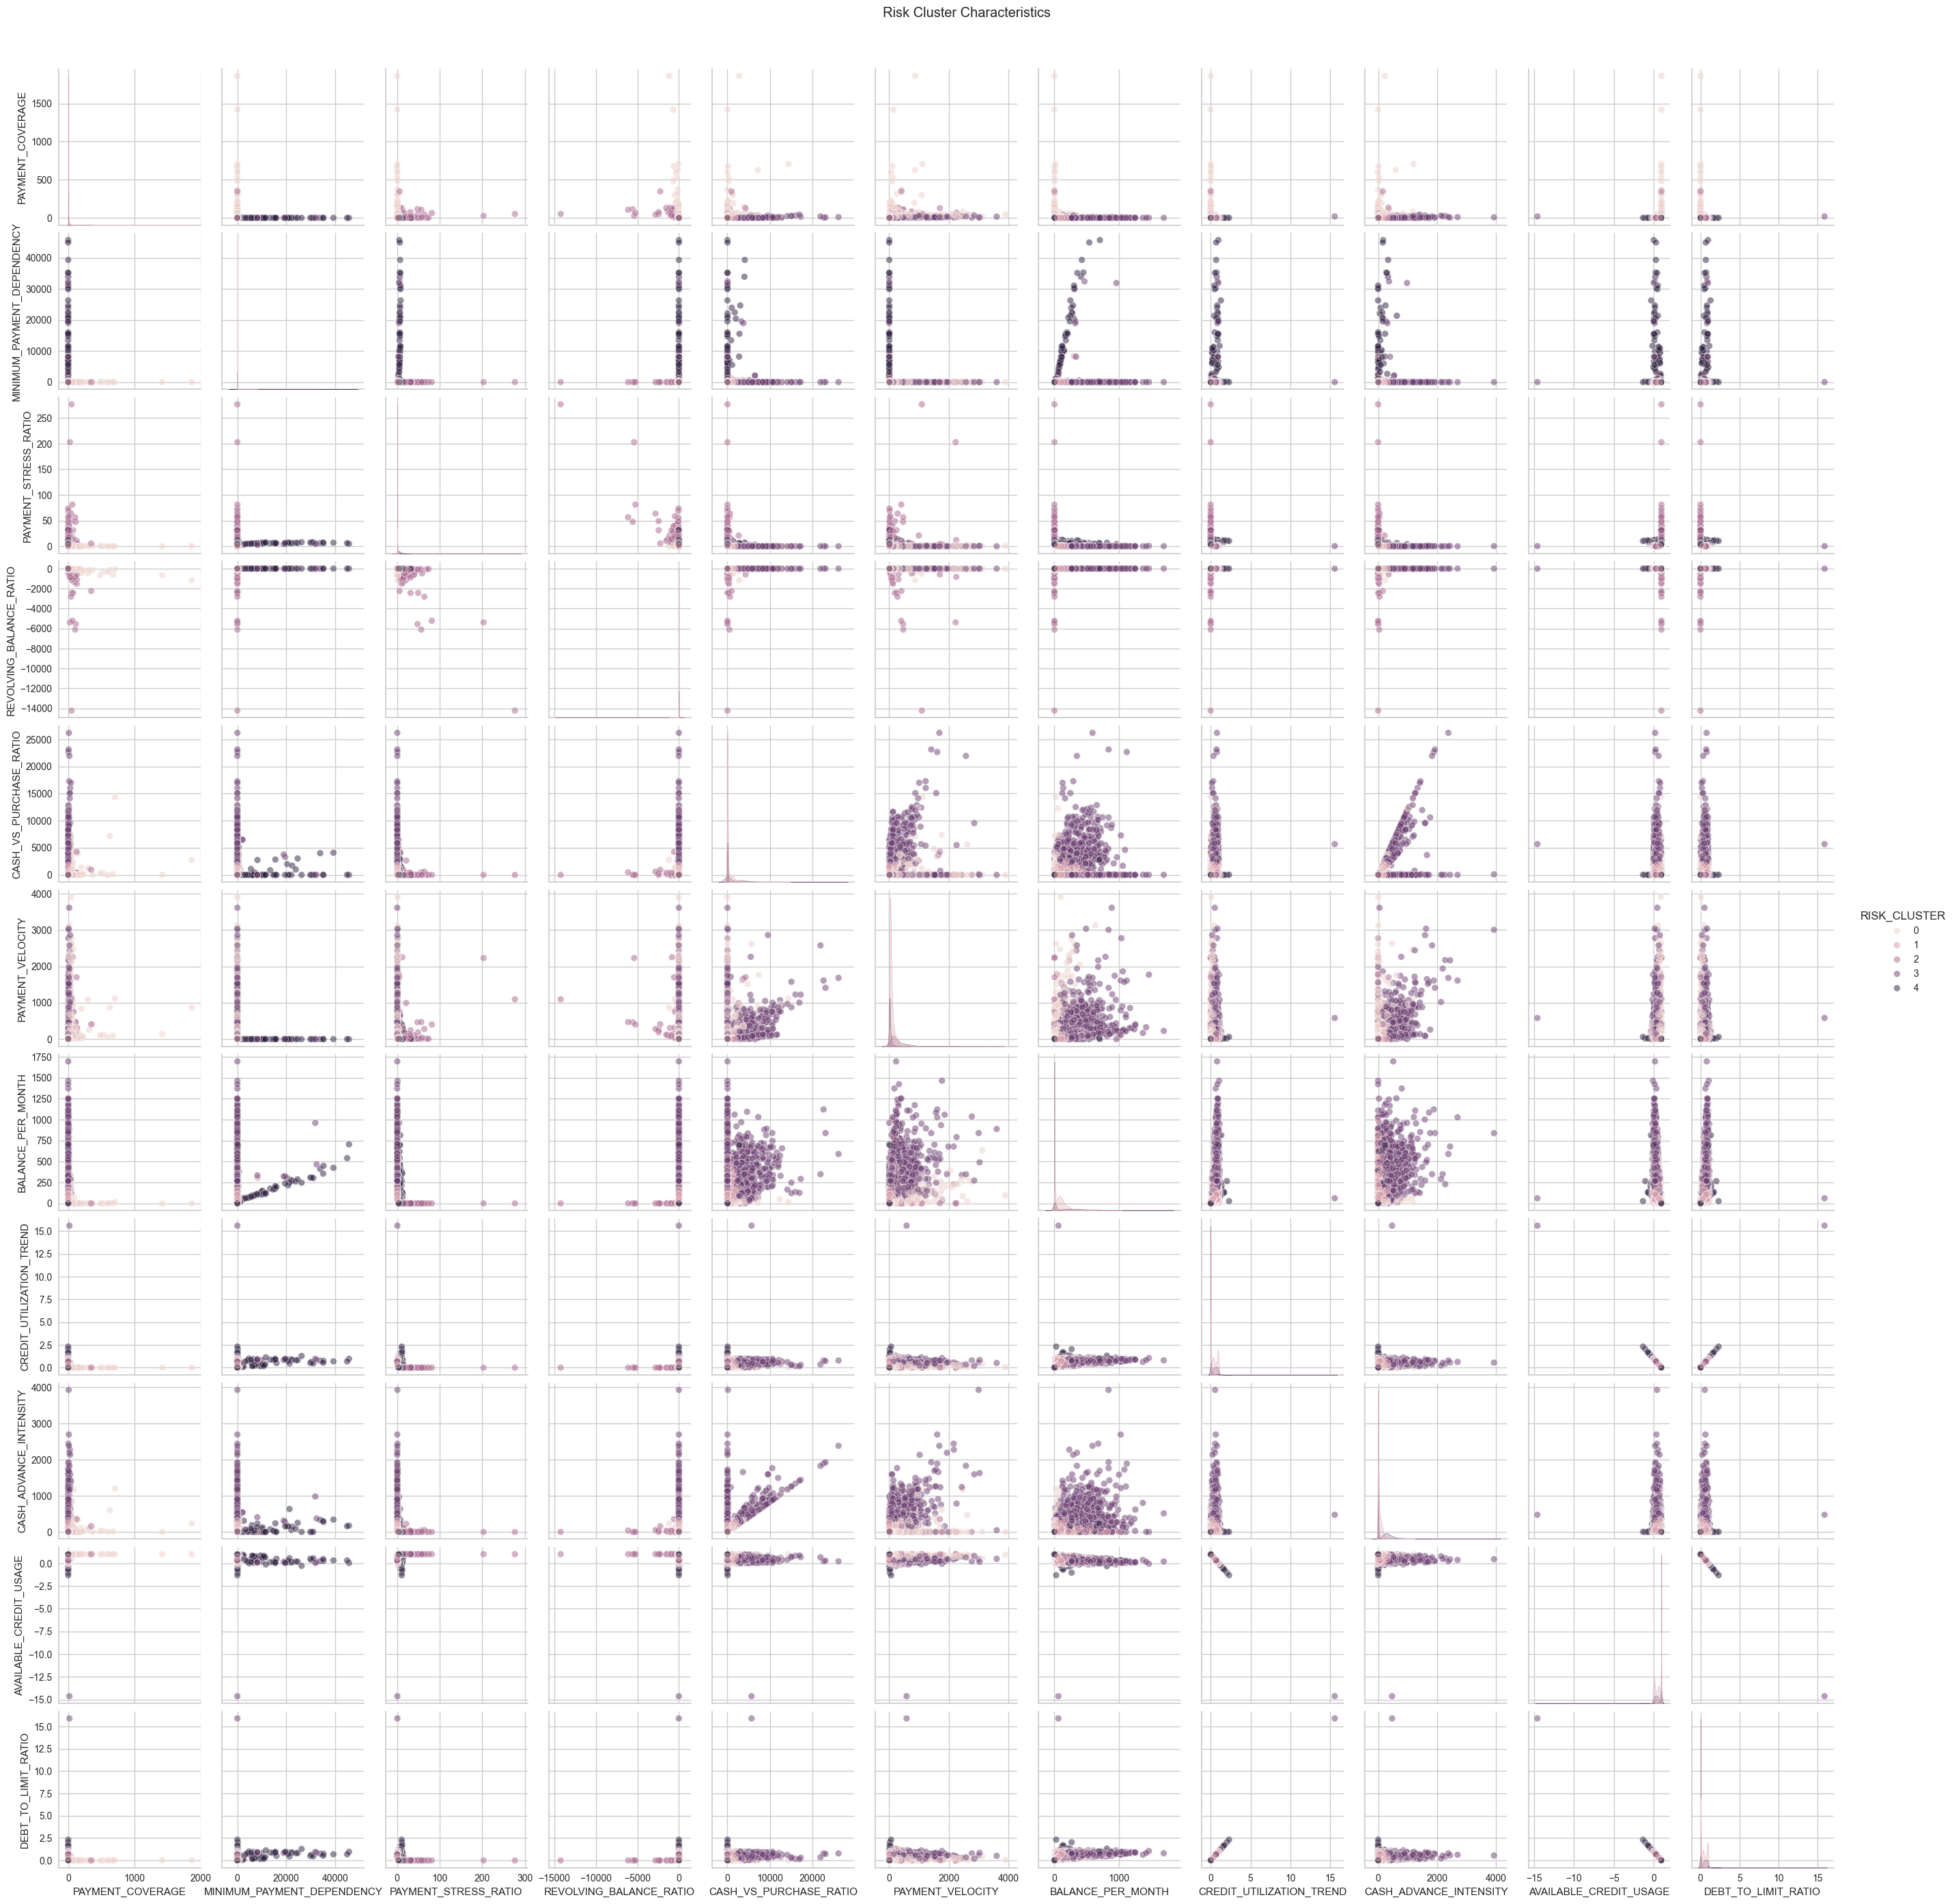

In [143]:
# 1. Pairplot of key risk features
sns.pairplot(
    df_risk,
    vars=risk_dimensions,
    hue='RISK_CLUSTER',
    diag_kind='kde',
    plot_kws={'alpha': 0.5}
)
plt.suptitle('Risk Cluster Characteristics', y=1.02)
plt.show()

In [144]:
visualizer = ClusterVisualizer(df_risk, cluster_labels, risk_features)

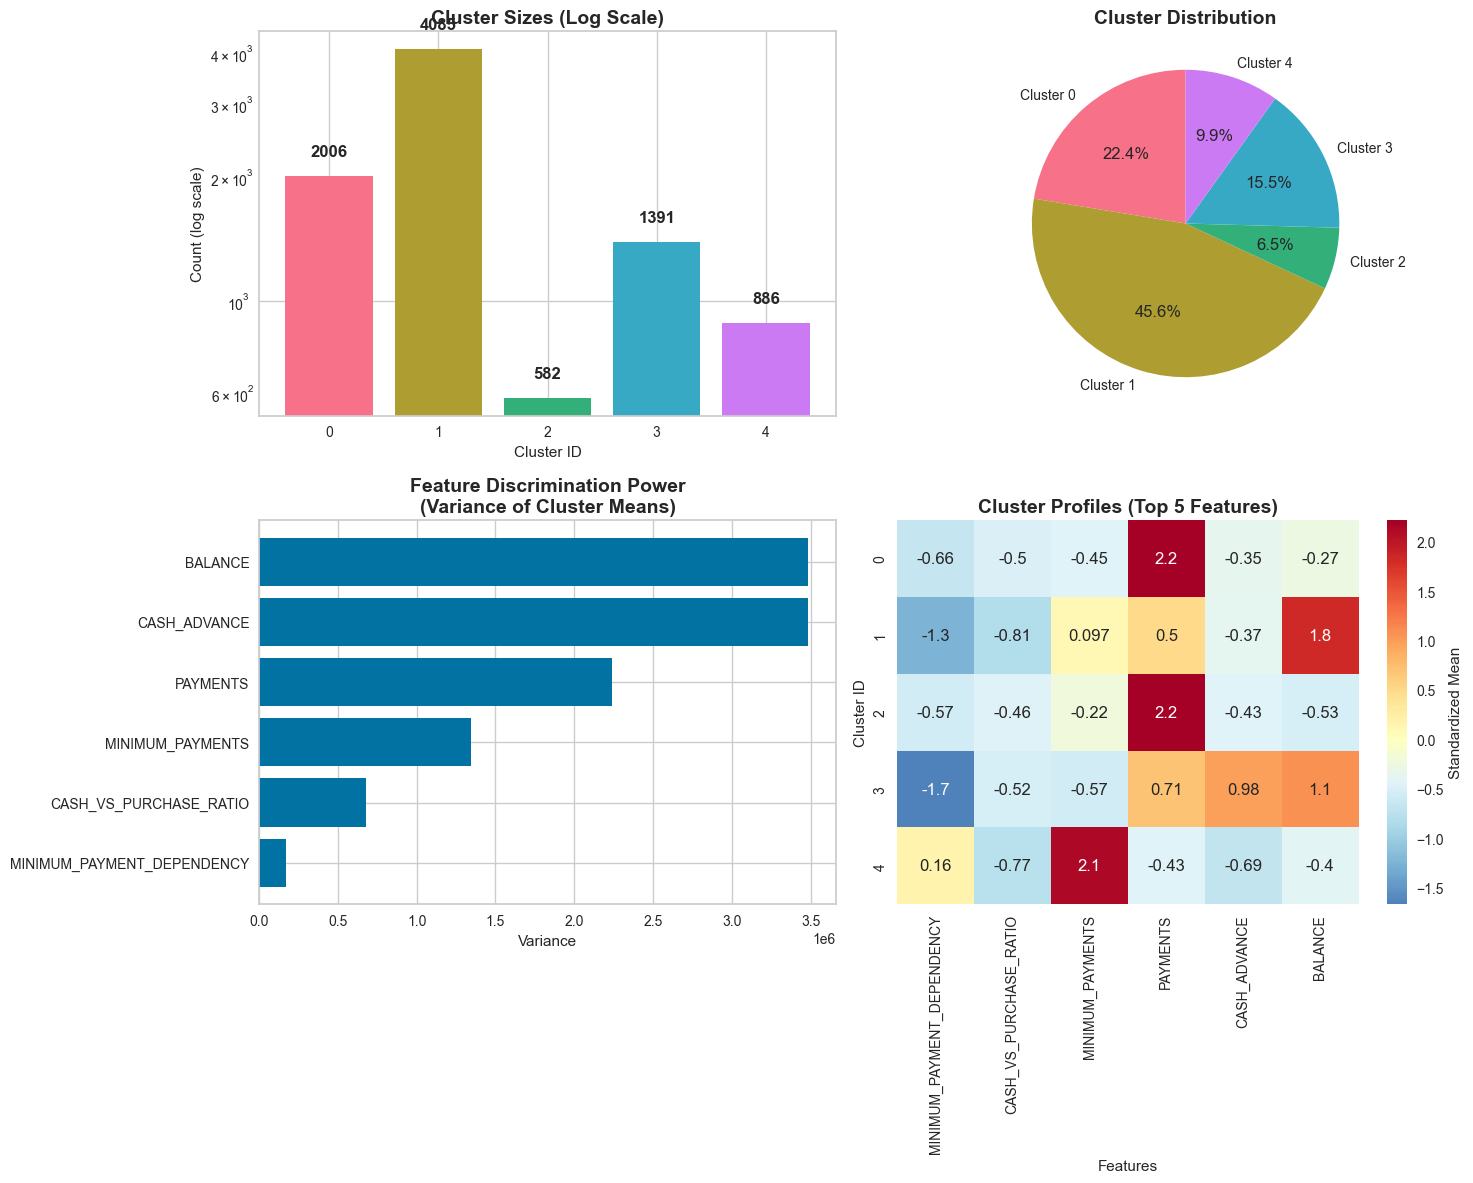

In [145]:
# Cluster Overview Analysis
fig1, disc_features = visualizer.plot_cluster_overview()
plt.show()

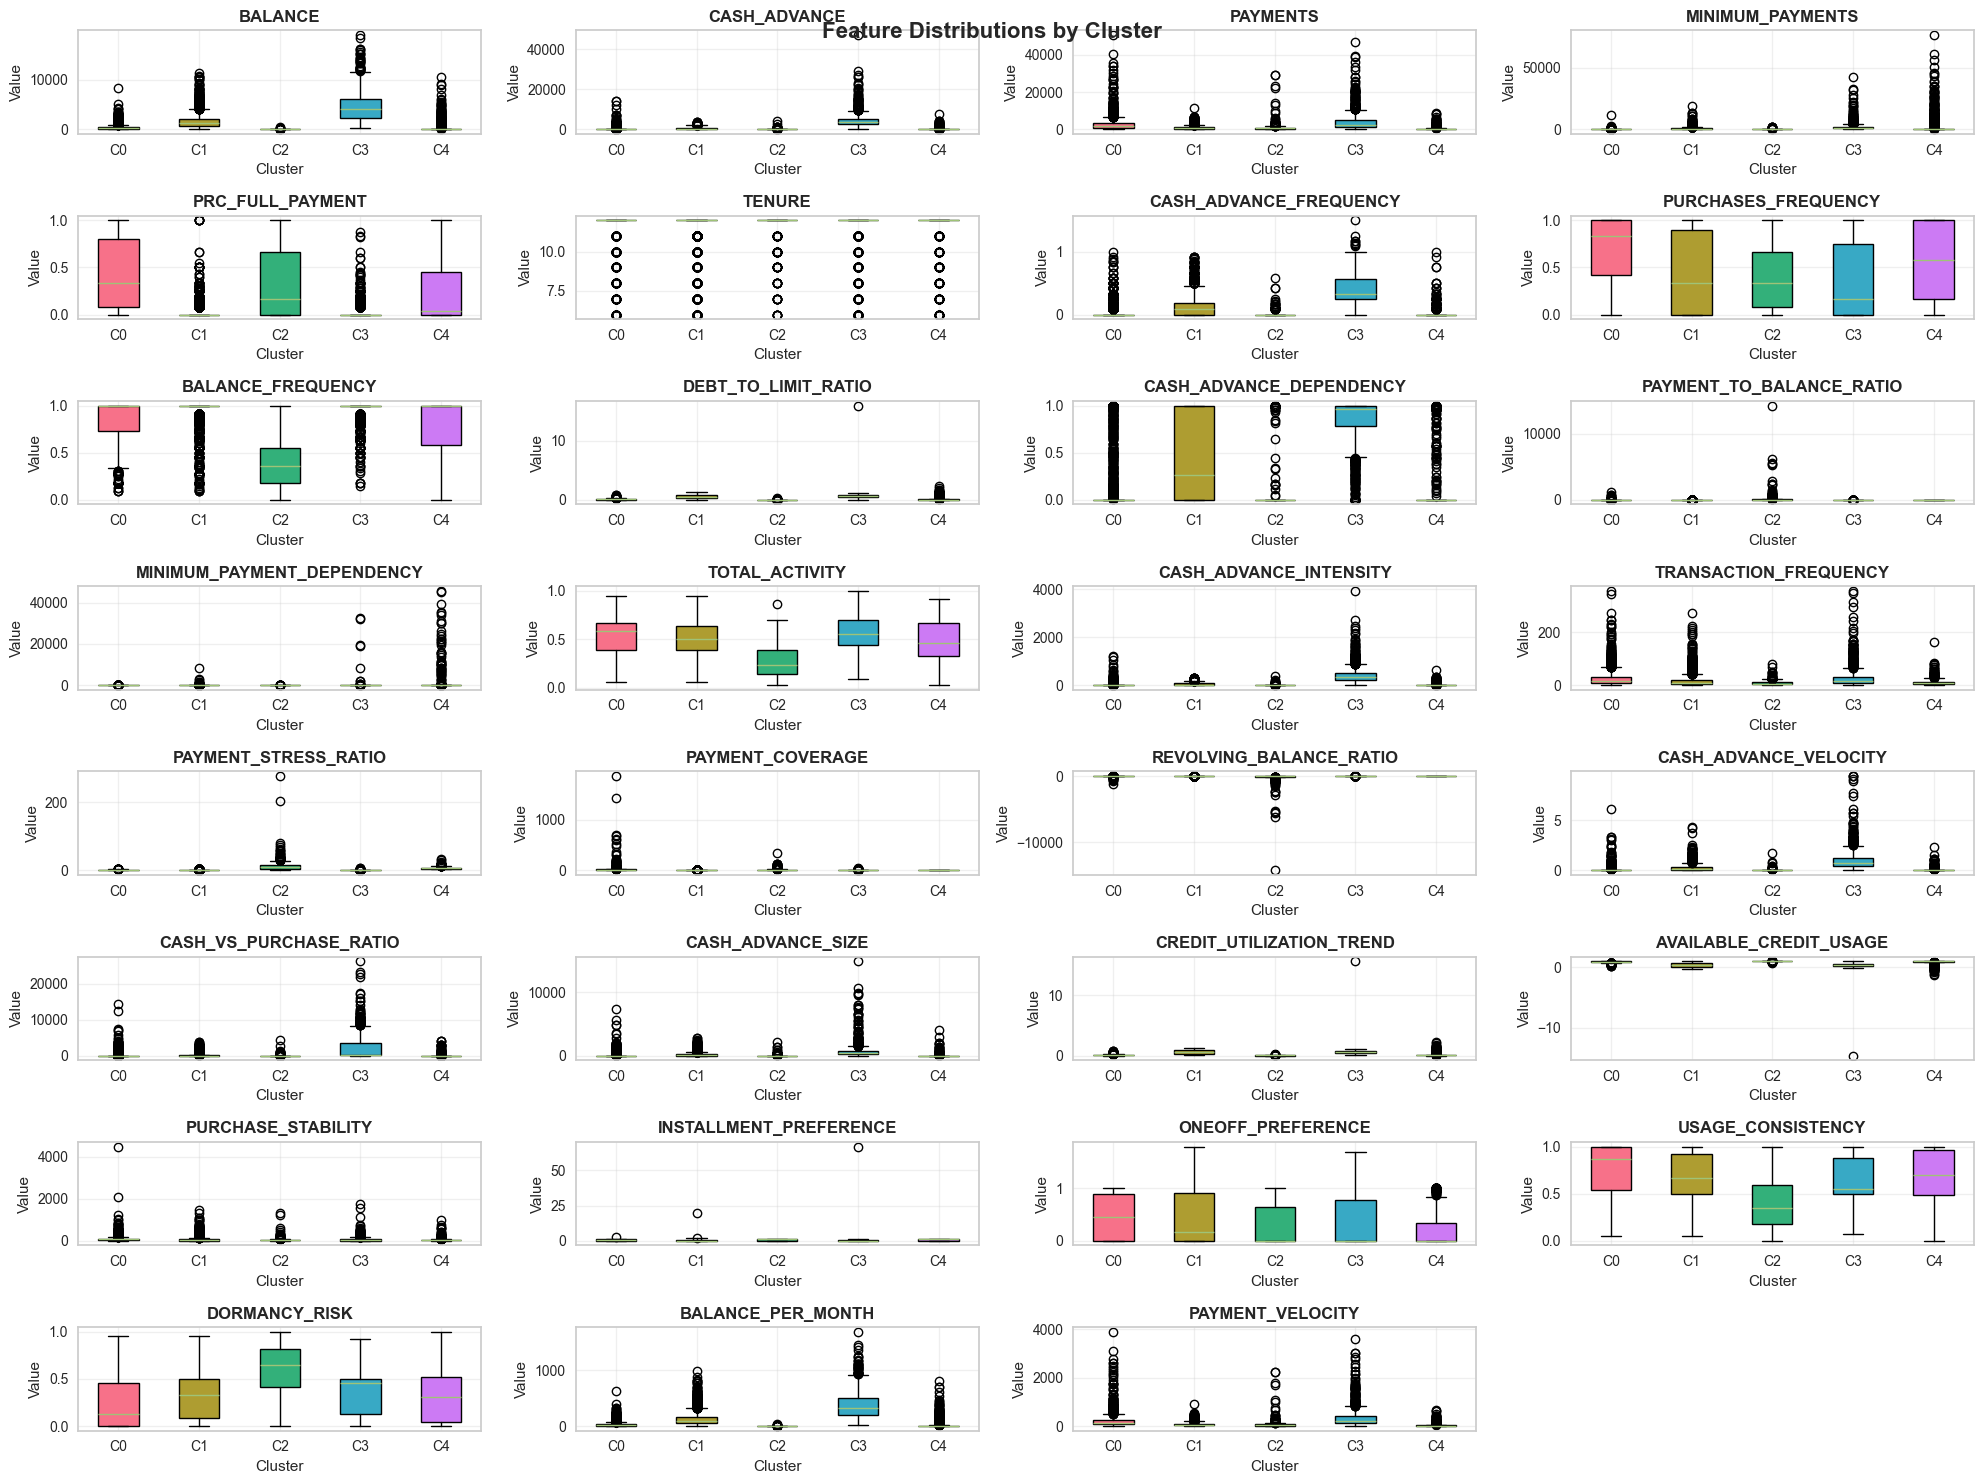

In [146]:
fig2 = visualizer.plot_feature_distributions()
fig2.suptitle('Feature Distributions by Cluster', fontsize=16, fontweight='bold')
plt.show()

In [147]:
fig3 = visualizer.plot_cash_advance_ratio()
fig3.show()

In [148]:
fig4 = visualizer.plot_min_payment_dependency()
fig4.show()

In [149]:
fig5 = visualizer.plot_risk_matrix()
fig5.show()

In [150]:
fig6 = visualizer.plot_debt_sustainability()
fig6.show()

In [151]:
options = visualizer.get_available_options()
print("Available clusters:", options['clusters'])
print("Available features:", options['features'])
print("Cluster sizes:", options['cluster_sizes'])
fig7 = visualizer.plot_cluster_profiles_radar_advanced()
fig7.show()

Available clusters: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4)]
Available features: ['BALANCE', 'CASH_ADVANCE', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE', 'CASH_ADVANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'BALANCE_FREQUENCY', 'DEBT_TO_LIMIT_RATIO', 'CASH_ADVANCE_DEPENDENCY', 'PAYMENT_TO_BALANCE_RATIO', 'MINIMUM_PAYMENT_DEPENDENCY', 'TOTAL_ACTIVITY', 'CASH_ADVANCE_INTENSITY', 'TRANSACTION_FREQUENCY', 'PAYMENT_STRESS_RATIO', 'PAYMENT_COVERAGE', 'REVOLVING_BALANCE_RATIO', 'CASH_ADVANCE_VELOCITY', 'CASH_VS_PURCHASE_RATIO', 'CASH_ADVANCE_SIZE', 'CREDIT_UTILIZATION_TREND', 'AVAILABLE_CREDIT_USAGE', 'PURCHASE_STABILITY', 'INSTALLMENT_PREFERENCE', 'ONEOFF_PREFERENCE', 'USAGE_CONSISTENCY', 'DORMANCY_RISK', 'BALANCE_PER_MONTH', 'PAYMENT_VELOCITY']
Cluster sizes: {0: 2006, 1: 4085, 2: 582, 3: 1391, 4: 886}


In [152]:
# fig5 = visualizer.plot_summary_statistics()
# fig5.suptitle('Comprehensive Cluster Analysis', fontsize=16, fontweight='bold')
# plt.show()

### Business Implementation

In [153]:
# ### Create segment-specific business rules
# rules = {}

# for risk_level in df_risk['RISK_LEVEL'].unique():
#     segment_data = df_risk[df_risk['RISK_LEVEL'] == risk_level]
    
#     rules[risk_level] = {
#         'credit_limit_multiplier': 1.2 if risk_level == 'LOW_RISK' else 
#                                 1.0 if risk_level == 'MEDIUM_RISK' else 0.8,
#         'interest_rate_adjustment': -0.02 if risk_level == 'LOW_RISK' else 
#                                 0.0 if risk_level == 'MEDIUM_RISK' else 0.03,
#         'cash_advance_limit': 0.8 if risk_level == 'LOW_RISK' else 
#                             0.5 if risk_level == 'MEDIUM_RISK' else 0.3,
#         'monitoring_frequency': 'Quarterly' if risk_level == 'LOW_RISK' else 
#                             'Monthly' if risk_level == 'MEDIUM_RISK' else 'Weekly'
#     }

# print("=== BUSINESS IMPLEMENTATION RULES ===\n")
# for risk_level, rule in rules.items():
#     print(f"{risk_level}:")
#     print(f"  Credit Limit Multiplier: {rule['credit_limit_multiplier']}")
#     print(f"  Interest Rate Adjustment: {rule['interest_rate_adjustment']:+.2%}")
#     print(f"  Cash Advance Limit: {rule['cash_advance_limit']:.0%} of credit limit")
#     print(f"  Monitoring Frequency: {rule['monitoring_frequency']}")
#     print()

### A/B testing

In [154]:
# Split each risk segment for testing
test_groups = {}

for risk_level in df_risk['RISK_LEVEL'].unique():
    segment_data = df_risk[df_risk['RISK_LEVEL'] == risk_level].copy()
    
    # Random split
    np.random.seed(42)
    segment_data['TEST_GROUP'] = np.random.choice(['Control', 'Treatment'], size=len(segment_data))
    
    test_groups[risk_level] = {
        'control_size': len(segment_data[segment_data['TEST_GROUP'] == 'Control']),
        'treatment_size': len(segment_data[segment_data['TEST_GROUP'] == 'Treatment'])
    }

print("=== A/B TESTING FRAMEWORK ===\n")
for risk_level, groups in test_groups.items():
    print(f"{risk_level}:")
    print(f"  Control Group: {groups['control_size']} customers")
    print(f"  Treatment Group: {groups['treatment_size']} customers")
    print()

KeyError: 'RISK_LEVEL'